# Importing Libraries

In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install statsmodels
%pip install matplotlib
%pip install pmdarima
%pip install numpy
%pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import random
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but RandomForestRegressor was fitted with feature names"
)

In [ ]:
treasury_data = pd.read_csv('10YrTsy.csv')
nasdaq_data = pd.read_csv('NasdaqData.csv')
gdp_data = pd.read_csv('GDP.csv')
inflation_data = pd.read_csv('Inflation.csv')
unemployment_data = pd.read_csv('Unemployment.csv')
fed_rates_data = pd.read_csv('FedRates.csv')  

In [ ]:
nasdaq_data

In [ ]:
treasury_data.rename(columns = {'DGS10':'10YrTsy'}, inplace = True)
nasdaq_data.rename(columns = {'Close':'NASDAQ Composite'}, inplace = True)
unemployment_data.rename(columns = {'UNRATE':'UnemploymentRate'}, inplace = True)
inflation_data.rename(columns = {'FPCPITOTLZGUSA':'Inflation'}, inplace = True)
gdp_data.rename(columns = {'GDPC1':'GDP'}, inplace = True)
fed_rates_data.rename(columns = {'DFF':'FFR'}, inplace = True)

In [ ]:
data = pd.merge(treasury_data, nasdaq_data, on='DATE', how='right')
data = pd.merge(data, gdp_data, on='DATE', how='left')
data = pd.merge(data, inflation_data, on='DATE', how='left')
data = pd.merge(data, unemployment_data, on='DATE', how='left')
data = pd.merge(data, fed_rates_data, on='DATE', how='left')
data = data.sort_values(by='DATE')
data

In [ ]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data['DATE'] >= pd.to_datetime('1986-01-01')]
data.iloc[0,1] = 7.3
data

In [ ]:
print("Number of NaNs in each column:")
print(data.isnull().sum())

# Data Cleaning

In [ ]:
data.isnull().sum()

In [ ]:
data['10YrTsy'] = data['10YrTsy'].replace('.', np.nan).astype(float)
data = data.ffill()
data.dropna(inplace=True)
data.isnull().sum()

In [ ]:
data

In [ ]:
new_row = {
    'DATE': pd.to_datetime('2024-09-19'),
    '10YrTsy': 3.73,
    'NASDAQ Composite': 20000,
    'GDP': 22924.863,
    'Inflation': 4.116338,
    'UnemploymentRate': 4.1,
    'FFR': 4.83
}

data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)
data

In [ ]:
data.loc['1986-01-01','10YrTsy'] = 7.3
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data[data['DATE'] >= pd.to_datetime('1986-01-01')]
data

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 15))
ax1.set_facecolor('black')
ax2 = ax1.twinx()
ax2.set_facecolor('black')

ax1.plot(data.index, data['NASDAQ Composite'], label='NASDAQ Composite', color='b')
ax1.plot(data.index, data['GDP'], label='GDP', color='r')
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Economic Indicators', fontsize=20)

ax2.plot(data.index, data['FFR'], label='FFR', color='orange', linestyle='--')
ax2.plot(data.index, data['UnemploymentRate'], label='Unemployment Rate', color='m')
ax2.plot(data.index, data['Inflation'], label='Inflation', color='c')
ax2.plot(data.index, data['10YrTsy'], label='10YrTsy', color='g')
ax2.set_ylabel('Economic Indicators', fontsize=20)

ax1.tick_params(axis='x', colors='white', labelsize=18)
ax1.tick_params(axis='y', colors='white', labelsize=18)
ax2.tick_params(axis='y', colors='white', labelsize=18)

ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper right', fontsize=18)

plt.title('Economic Indicators', fontsize=25, color='white')
plt.xticks(rotation=45, color='white')
plt.gcf().set_facecolor('black')

plt.tight_layout()

# Display the plot
plt.show()


# Train Data

In [ ]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data = data[~data.index.duplicated(keep='first')]
data

### Train NASDAQ Data

In [ ]:
nasdaq_data = data
nasdaq_data.head(5)

In [ ]:
nasdaq_data['Volatility5'] = nasdaq_data['NASDAQ Composite'].rolling(window=5).std()
nasdaq_data['Momentum'] = nasdaq_data['NASDAQ Composite'] - nasdaq_data['NASDAQ Composite'].shift(5)
nasdaq_data['Returns'] = nasdaq_data['NASDAQ Composite'].pct_change()
nasdaq_data.dropna(inplace=True)

corr_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

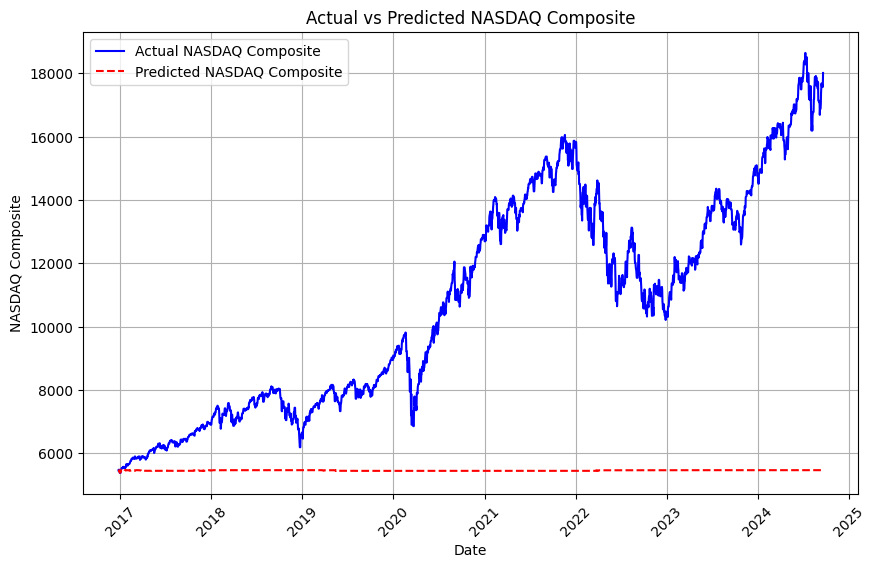

In [214]:
X = nasdaq_data[['10YrTsy','NASDAQ Composite','GDP','Inflation','UnemploymentRate', 'Volatility5', 'Momentum', 'Returns', 'FFR']]
y = nasdaq_data['NASDAQ Composite']
train_size = int(len(nasdaq_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y_test = y_test.reset_index()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model_fed = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=15,
    min_samples_split=5,  
    min_samples_leaf=2,  
    random_state=42
)
rf_model_fed.fit(X_train_scaled, y_train)
y_pred = rf_model_fed.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.plot(y_test['DATE'], y_test['NASDAQ Composite'], label='Actual NASDAQ Composite', linestyle='-', color='blue')
plt.plot(y_test['DATE'], y_pred, label='Predicted NASDAQ Composite', linestyle='--', color='red')
plt.title('Actual vs Predicted NASDAQ Composite')
plt.xlabel('Date')
plt.ylabel('NASDAQ Composite')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
mse_rf = mean_squared_error(y_test['NASDAQ Composite'], y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test['NASDAQ Composite'], y_pred)

print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R2 Score): {r2_rf}")

In [ ]:
rf_model_fed = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=None,      
    min_samples_split=5, 
    min_samples_leaf=2,
    random_state=42
)
rf_model_fed.fit(X_train, y_train)
y_pred = rf_model_fed.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Compare actual vs predicted using a graph
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual NASDAQ Composite', marker='o')
plt.plot(y_pred, label='Predicted NASDAQ Composite', marker='x')
plt.title('Actual vs Predicted NASDAQ Composite')
plt.xlabel('Data Points')
plt.ylabel('NASDAQ Composite')
plt.legend()
plt.grid(True)
plt.show()

# Display metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2 Score): {r2}")

In [ ]:
last_row = X_test.iloc[-1].values.reshape(1, -1)
predictions_rf_fed = []

for _ in range(60):
    next_pred = rf_model_fed.predict(last_row)
    fluctuation = next_pred[0] + random.uniform(-50, 100)  
    predictions_rf_fed.append(fluctuation)
    last_row = np.array([last_row[0][1], last_row[0][2], last_row[0][3], fluctuation, last_row[0][4]]).reshape(1, -1)
for _ in range(60,120):
    next_pred = rf_model_fed.predict(last_row)
    fluctuation = next_pred[0] + random.uniform(-100, 200)  
    predictions_rf_fed.append(fluctuation)
    last_row = np.array([last_row[0][1], last_row[0][2], last_row[0][3], fluctuation, last_row[0][4]]).reshape(1, -1)
for _ in range(120,180):
    next_pred = rf_model_fed.predict(last_row)
    fluctuation = next_pred[0] + random.uniform(-50, 300)  
    predictions_rf_fed.append(fluctuation)
    last_row = np.array([last_row[0][1], last_row[0][2], last_row[0][3], fluctuation, last_row[0][4]]).reshape(1, -1)

last_nasdaq_value = nasdaq_data['NASDAQ Composite'].iloc[-1]
nasdaq_predictions = [pred * (last_nasdaq_value / 5464.08) for pred in predictions_rf_fed]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(nasdaq_data['NASDAQ Composite'], label='Original Data')
plt.plot(pd.date_range(start=nasdaq_data.index[-1], periods=181, freq='D')[1:], nasdaq_predictions, label='Predicted Data', color='green')
plt.title('Predicted Data')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
#plt.plot(nasdaq_data['NASDAQ Composite'], label='Original Data')
plt.plot(pd.date_range(start=nasdaq_data.index[-1], periods=181, freq='D')[1:], nasdaq_predictions, label='Predicted Data', color='green')
plt.title('Predicted Data')
plt.legend()
plt.show()